In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [4]:
# Read in file
df = pd.read_csv("creditcard.csv")

In [5]:
# View shape of the data
df.shape

(284807, 31)

In [6]:
# Check for missing values
df.isnull().values.any()

False

Text(0,0.5,'Frequency')

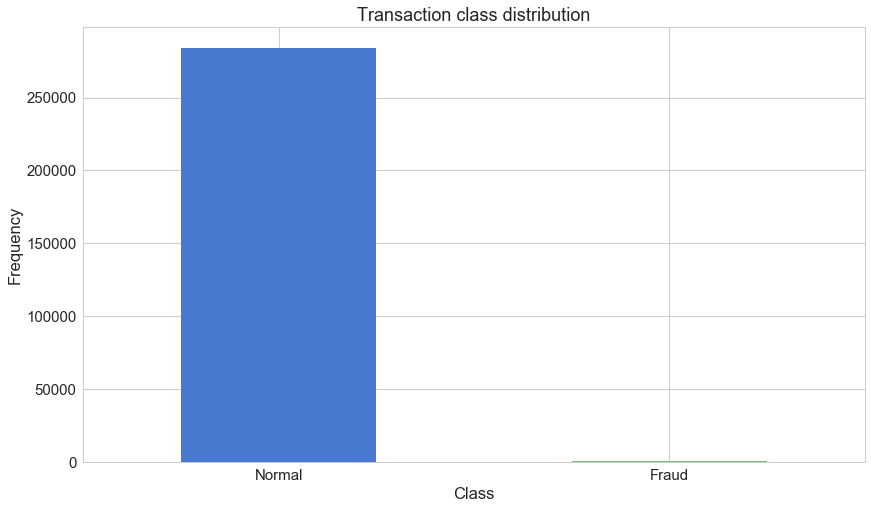

In [7]:
# Plot histogram of Transaction class distribution
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [8]:
# Review of the two normal types of transactions
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [9]:
# View shape of frauds
frauds.shape

(492, 31)

In [10]:
# View shape of normals
normal.shape

(284315, 31)

In [11]:
# Get summary stats for frauds
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
# Get summary stats for normal
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

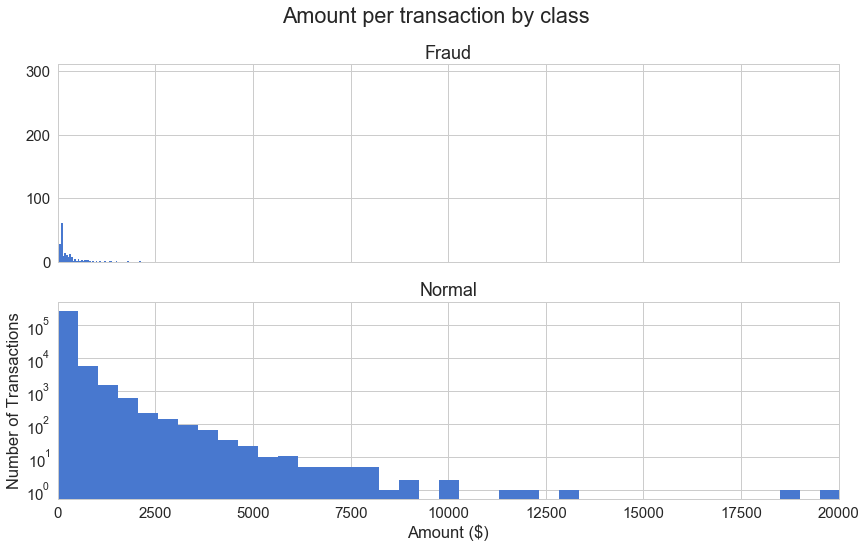

In [13]:
# Graphical representation of fraudulent vs normal transactions
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

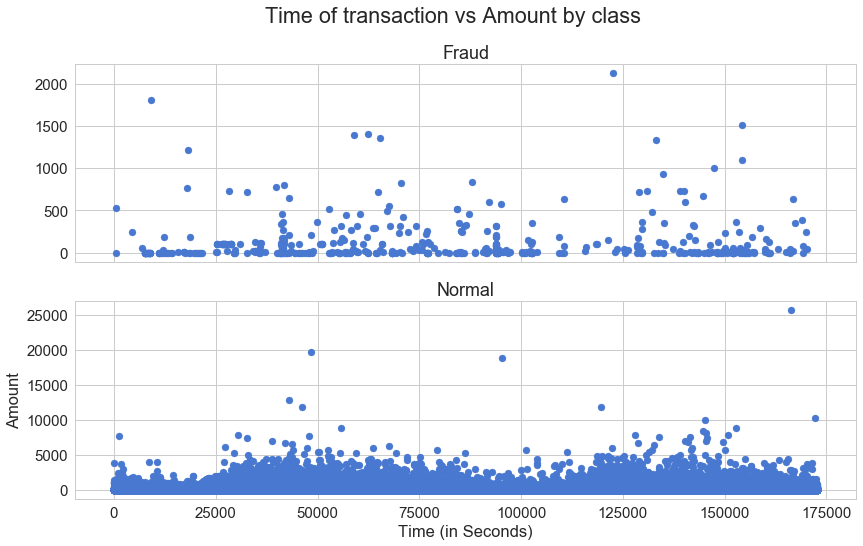

In [14]:
# Do fraudulent transactions occur more often during a 
# certain time?
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler

# Drop time column ~ we will not be using
data = df.drop(['Time'], axis=1)

# Use scikits StandardScaler on the amount
# Scaler removes the mean and scales the values to 
# unit variance:
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))


In [16]:
# Training the Autoencoder, we reserve 20% of our data
# for testing
# Since we have a great deal of non fraudulent transactions 
# and we are trying to detect any anomaly on new transactions, 
# We create this situation by training our model on 
# normal transactions only. 
X_train, X_test = train_test_split(data, test_size=0.2,
random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape


(227451, 29)

In [17]:
# The Autoencoder uses 4 fully connected layers with 14, 7, 7, and 
# 29 neurons respectively.
# The first two layers are used for the encoder, the last two
# are for the decoder
# L1 regularization will be used during training
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
               activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [18]:
# Train the model for 100 epochs with a batch size of 32 samples. 
# Save the best performing mode to a file.
# The training progress will be exported in a format that 
# TensorBoard understands
nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam',
                   loss='mean_squared_error',
                   metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                              verbose=0,
                              save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                         histogram_freq=0,
                         write_graph=True,
                         write_images=True)

history = autoencoder.fit(X_train, X_train,
                         epochs=nb_epoch,
                         batch_size=batch_size,
                         shuffle=True,
                         validation_data=(X_test, X_test),
                         verbose=1,
                         callbacks=[checkpointer, tensorboard]).history


Train on 227451 samples, validate on 56962 samples
Epoch 1/10
227451/227451 [==============================] - 13s 57us/step - loss: 0.8186 - acc: 0.5980 - val_loss: 0.7957 - val_acc: 0.6601
Epoch 2/10
227451/227451 [==============================] - 12s 52us/step - loss: 0.7584 - acc: 0.6664 - val_loss: 0.7824 - val_acc: 0.6724
Epoch 3/10
227451/227451 [==============================] - 12s 55us/step - loss: 0.7491 - acc: 0.6746 - val_loss: 0.7787 - val_acc: 0.6664
Epoch 4/10
227451/227451 [==============================] - 12s 53us/step - loss: 0.7444 - acc: 0.6753 - val_loss: 0.7739 - val_acc: 0.6688
Epoch 5/10
227451/227451 [==============================] - 14s 62us/step - loss: 0.7399 - acc: 0.6776 - val_loss: 0.7725 - val_acc: 0.6791
Epoch 6/10
227451/227451 [==============================] - 13s 57us/step - loss: 0.7368 - acc: 0.6817 - val_loss: 0.7816 - val_acc: 0.6704
Epoch 7/10
227451/227451 [==============================] - 13s 58us/step - loss: 0.7353 - acc: 0.6828 - val_

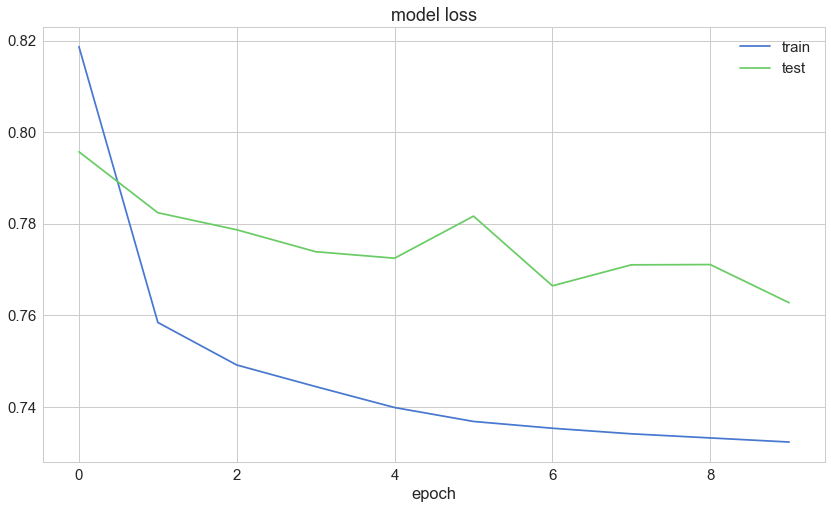

In [20]:
# Evaluation
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [21]:
# Review the error distribution
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.756289,0.001720
std,3.482213,0.041443
min,0.067001,0.000000
25%,0.252653,0.000000
50%,0.401052,0.000000
75%,0.623920,0.000000
max,262.237788,1.000000


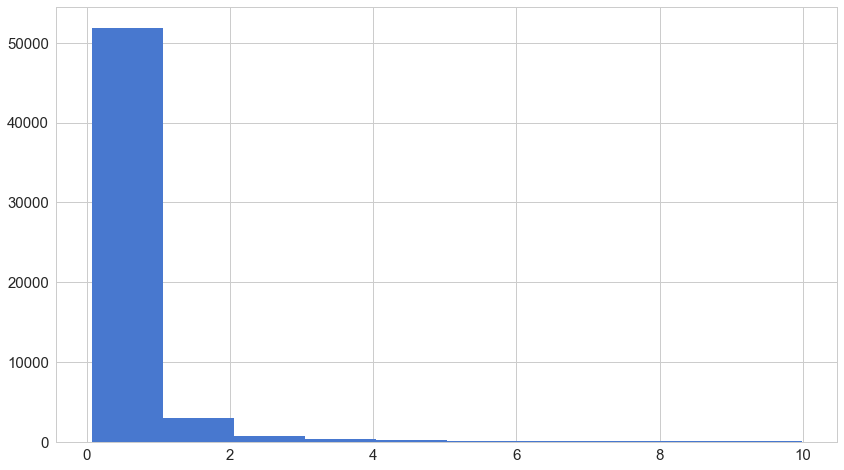

In [22]:
# Build histogram showing reconstruction error without fraud
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) &
                           (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins = 10)

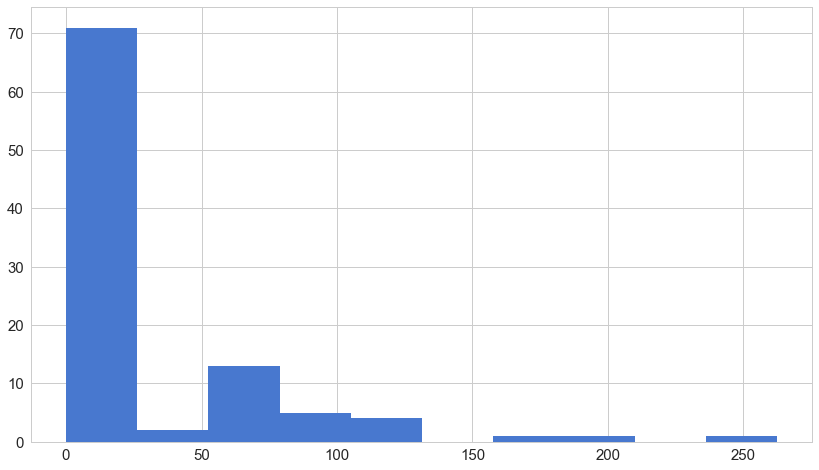

In [23]:
# Build a histogram showing reconstruction error with fraud
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [24]:
# Import metrics to measure our model
from sklearn.metrics import (confusion_matrix, precision_recall_curve,
                            auc, roc_curve, recall_score, classification_report,
                            f1_score, precision_recall_fscore_support)

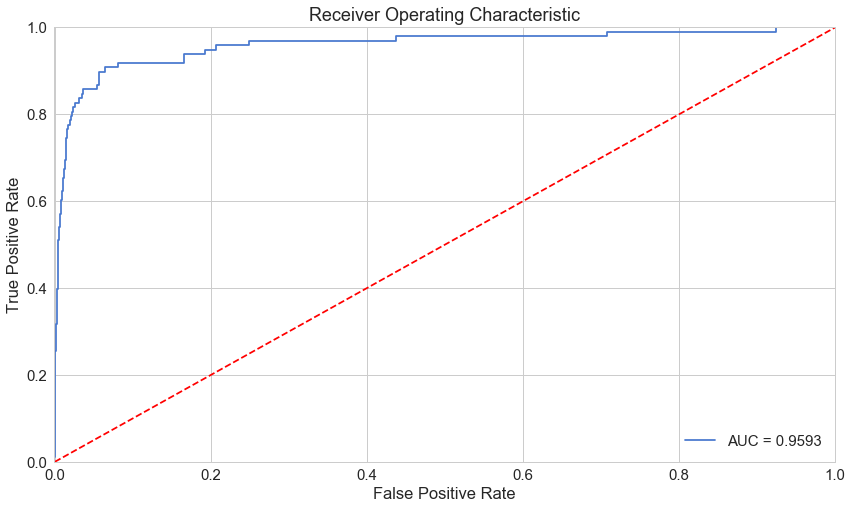

In [25]:
# Construct ROC curve to understand the performance of the binary classifier
fpr, tpr, thresholds = roc_curve(error_df.true_class,
                                error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()         

<function matplotlib.pyplot.show(*args, **kw)>

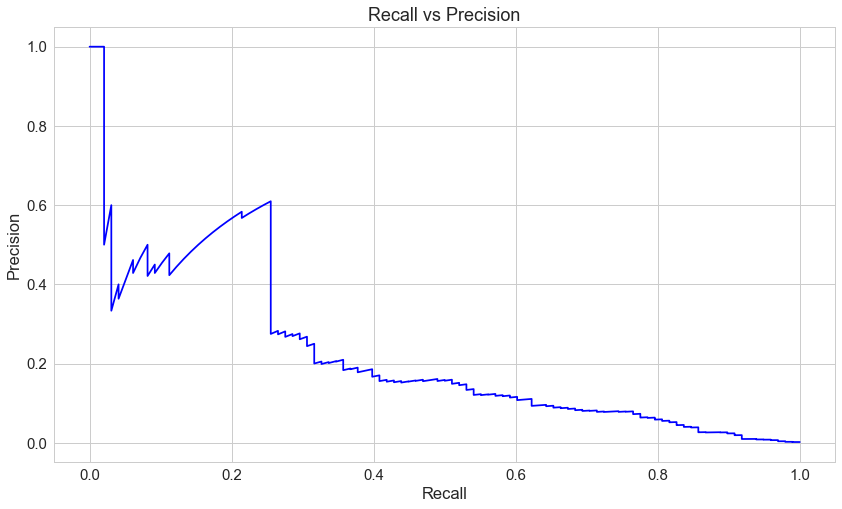

In [26]:
# Precision vs recall chart
precision, recall, th = precision_recall_curve(error_df.true_class,
                                              error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label="Precision-Recall curve")
plt.title("Recall vs Precision")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show

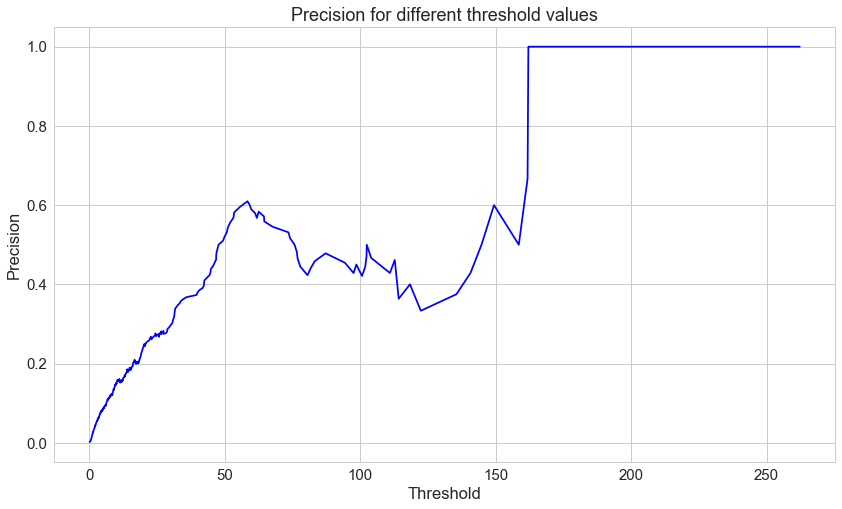

In [27]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()